## **Model 1: Simple baseline model**

**Baseline model**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Dataset (only resizing, no normalization, no augmentation)
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42

train_dir = "datasets/Training"
test_dir  = "datasets/Testing"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False)


Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


**Split train/val**

In [2]:
val_size = int(0.2 * len(train_ds))
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

**Build baseline CNN**

In [11]:
def build_baseline_cnn(input_shape=(128,128,3), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [12]:
model1 = build_baseline_cnn()
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

**Compile model**

In [13]:
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

**Train model**

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss',
                  patience=5,
                  min_delta=1e-3,
                  restore_best_weights=True,
                  verbose=1),
    ModelCheckpoint('models/model01_best.h5',
                    monitor='val_loss',
                    save_best_only=True,
                    verbose=1),
    ReduceLROnPlateau(monitor='val_loss',
                      factor=0.5,
                      patience=3,
                      min_lr=1e-6,
                      verbose=1)
]

history1 = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,            # increase epochs, EarlyStopping will stop earlier if no improvement
    callbacks=callbacks
)


Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6025 - loss: 11.8555
Epoch 1: val_loss improved from None to 0.37016, saving model to models/model01_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 27s 180ms/step - accuracy: 0.7269 - loss: 3.2297 - val_accuracy: 0.8634 - val_loss: 0.3702 - learning_rate: 0.0010
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8826 - loss: 0.3150
Epoch 2: val_loss improved from 0.37016 to 0.29870, saving model to models/model01_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 27s 185ms/step - accuracy: 0.9033 - loss: 0.2659 - val_accuracy: 0.8955 - val_loss: 0.2987 - learning_rate: 0.0010
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9331 - loss: 0.1935
Epoch 3: val_loss improved from 0.29870 to 0.27723, saving model to models/model01_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 27s 190ms/step - accuracy: 0.9425 - loss: 0.1640 - val_accuracy: 0.9152 - val_loss: 0.2772 - learning_rate: 0.0010
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9607 - loss: 0.1130
Epoch 4: val_loss did not improve from 0.27723
144/144 ━━━━━━━━━━━━━━━━━━━━ 25s 172ms/step - accuracy: 0.9625 - loss: 0.1005 - val_accuracy: 0.9045 - val_loss: 0.4724 - learning_rate: 0.0010
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9760 - loss: 0.0812
Epoch 5: val_loss improved from 0.27723 to 0.25616, saving model to models/model01_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 25s 175ms/step - accuracy: 0.9745 - loss: 0.0800 - val_accuracy: 0.9339 - val_loss: 0.2562 - learning_rate: 0.0010
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9770 - loss: 0.0707
Epoch 6: val_loss did not improve from 0.25616
144/144 ━━━━━━━━━━━━━━━━━━━━ 25s 175ms/step - accuracy: 0.9776 - loss: 0.0640 - val_accuracy: 0.9259 - val_loss: 0.3054 - learning_rate: 0.0010
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9782 - loss: 0.0616
Epoch 7: val_loss did not improve from 0.25616
144/144 ━━━━━━━━━━━━━━━━━━━━ 24s 170ms/step - accuracy: 0.9808 - loss: 0.0581 - val_accuracy: 0.9205 - val_loss: 0.3443 - learning_rate: 0.0010
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9769 - loss: 0.0635
Epoch 8: val_loss did not improve from 0.25616

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
144/144 ━━━━━━━━━━━━━━━━━━━━ 25s 175ms/step - accuracy: 0.9817 - loss: 0.0491 - val_ac

**Evaluate on test set:**

In [15]:
# Evaluate on test set
test_loss, test_acc = model1.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Get final training & validation metrics
final_train_acc = history1.history['accuracy'][-1]
final_train_loss = history1.history['loss'][-1]
final_val_acc   = history1.history['val_accuracy'][-1]
final_val_loss  = history1.history['val_loss'][-1]

print(f"Final training accuracy: {final_train_acc:.4f}")
print(f"Final training loss: {final_train_loss:.4f}")
print(f"Final validation accuracy: {final_val_acc:.4f}")
print(f"Final validation loss: {final_val_loss:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9054 - loss: 0.3493
Test accuracy: 0.9054
Test loss: 0.3493
Final training accuracy: 0.9998
Final training loss: 0.0020
Final validation accuracy: 0.9464
Final validation loss: 0.2723


**Training-Validation loss curve**

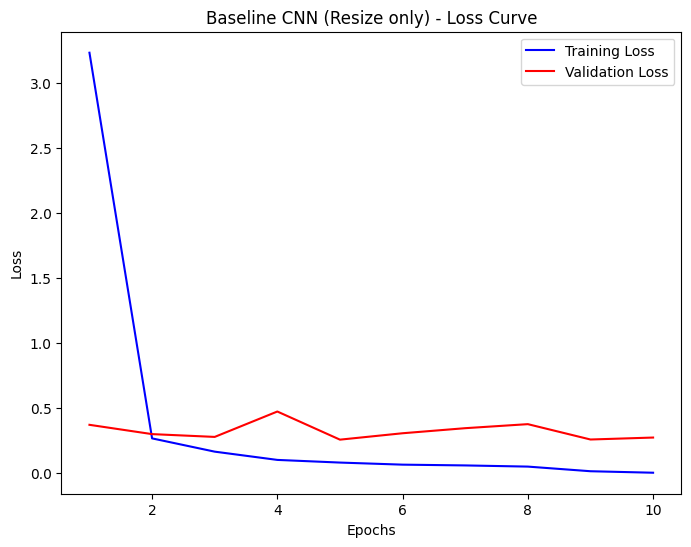

In [16]:
import matplotlib.pyplot as plt

# Training & Validation Loss curve
def plot_loss_curve(history, model_name="Model"):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'{model_name} - Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Example for Model 1
plot_loss_curve(history1, model_name="Baseline CNN (Resize only)")


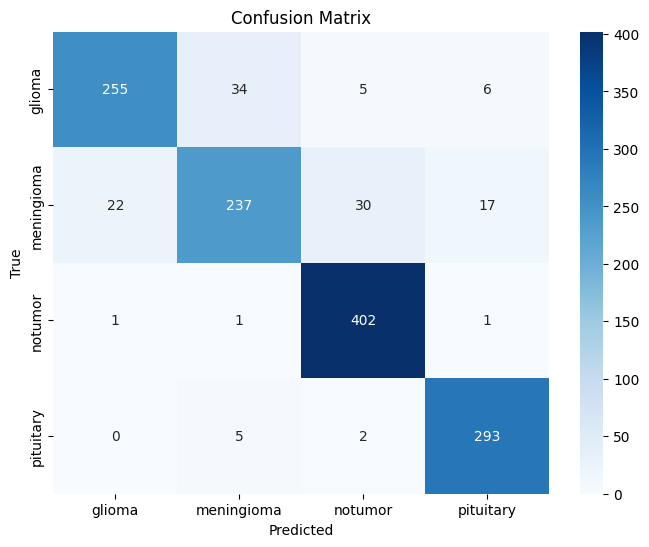


Classification Report:

              precision    recall  f1-score   support

      glioma       0.92      0.85      0.88       300
  meningioma       0.86      0.77      0.81       306
     notumor       0.92      0.99      0.95       405
   pituitary       0.92      0.98      0.95       300

    accuracy                           0.91      1311
   macro avg       0.90      0.90      0.90      1311
weighted avg       0.90      0.91      0.90      1311



In [3]:
from plot_utils import plot_confusion_matrix_from_dataset

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Confusion matrix from saved model
plot_confusion_matrix_from_dataset("models/model01_best.h5", test_ds, class_names)
